# Generating data for superpixel-based segmentation

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic, mark_boundaries, quickshift
from skimage.util import img_as_float
from skimage import io
import cv2
from multi_texton_histogram import MultiTexton
import glob 
import os
import random
import string
from skimage import data, img_as_float
from skimage import exposure
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import median
from skimage.morphology import disk

## Load image

In [3]:
IMAGE_NAME = "0A1E4A42-41CB-47F6-AB97-68EAF6D7D2C3_4666320B-C8B2-4350-8270-C4383B5903E6_000009"
IMG_PATH = '/home/daniel/Documents/data_science/data_cropped/gold/images/'
LABEL_PATH = '/home/daniel/Documents/data_science/data_cropped/gold/labels/'
FILE_NAME = os.path.join(IMG_PATH, IMAGE_NAME) + ".jpg"
LABEL_FILE_NAME = os.path.join(LABEL_PATH, IMAGE_NAME) + ".txt"

In [4]:
test_image = io.imread(FILE_NAME)

## Image Preprocessing

Our data is not preprocessed and has a lot of noise that makes finding damages harder. To improve situation, we use classical image processing techniques. What we first do is we cut off the high and low ends of the histogram by 2% and equalize it after that. This brings out more detail and makes highlights and shadows more equal, which should help us find damages using classical Machine Learning approaches.

In [5]:
def image_preprocessing(img):
    img = img_as_float(img)
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    return exposure.equalize_adapthist(img, clip_limit=0.03)

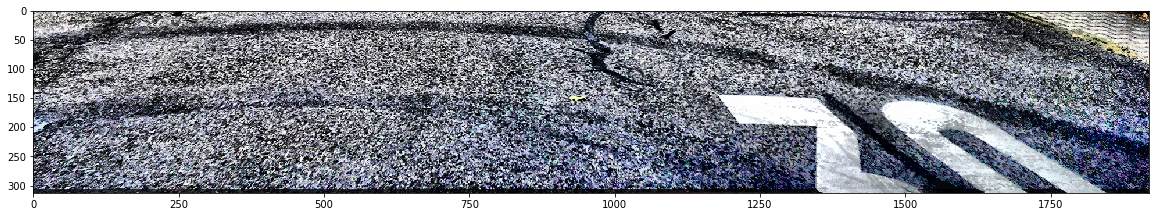

In [7]:
test_image = image_preprocessing(test_image)
plt.figure(figsize=(20,25))
plt.imshow(test_image)

## Apply the SLIC segmentation

This approach focuses on using a segmentation algorithm to split the image into smaller segments that are then classified. After that, we should be able to see a coarse segmentation result. 
Depending on the segmentation method (in this case, we use **SLIC**), the segments look different. Different segmenters look for different features in the picture with which they can cluster pixels together. There is a lot of Hyperparameter Tuning that can be done there to improve performance.

In [19]:
SEG_VAL = 20
N_SEGMENTS = 300

We can mask the segments and visualize them in the using the `mark_boundaries` method from skimage.

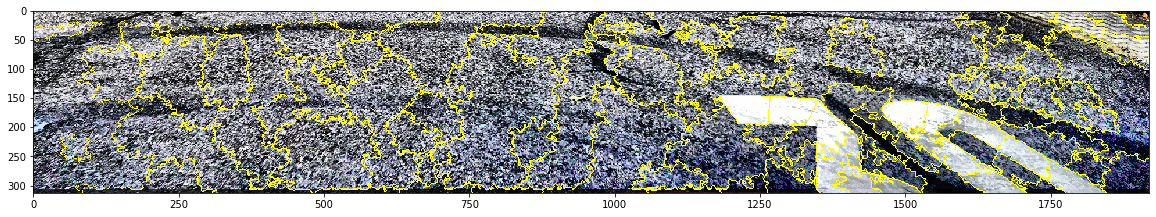

In [20]:
segments = slic(test_image, n_segments=N_SEGMENTS, compactness=10, sigma=1)
plt.figure(figsize=(20,25))
plt.imshow(mark_boundaries(test_image, segments))

### Crop out one single segment

The segmentation mask is a two-dimensional array with the segments marked by numbers. We can see below how the mask looks: 

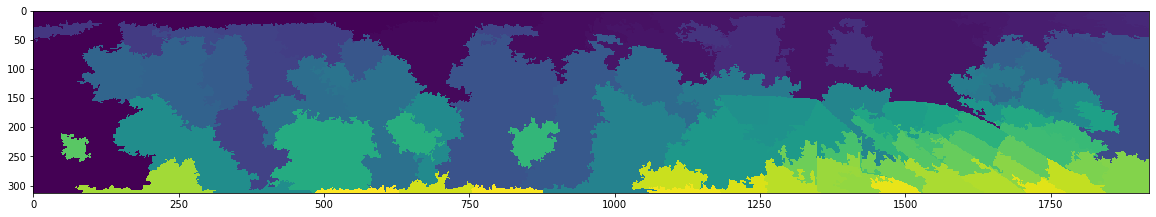

In [21]:
plt.figure(figsize=(20,25))
plt.imshow(segments)

The idea is to classify the the segments using a CNN. Since CNNs only accept rectangular input shapes, the idea is to pad each segment with zeros, making each of them rectangular. 

Every segment has an index. In the segmentation mask, every segmented reagion is filled with this index number. So, to extract one specific segment we need to locate each specific segment number and get the information of where this segment is located.

In [22]:
segment_locations = np.argwhere(segments == SEG_VAL)
segment_locations.shape

(20001, 2)

Then, we can superimpose a zero-image-mask with the segment as a white spot over the image. This can be best done using OpenCV.

In [23]:
mask = np.zeros(test_image.shape[:2], dtype = "uint8")
mask[segments == SEG_VAL] = 255
mask = cv2.bitwise_and(test_image, test_image, mask = mask)

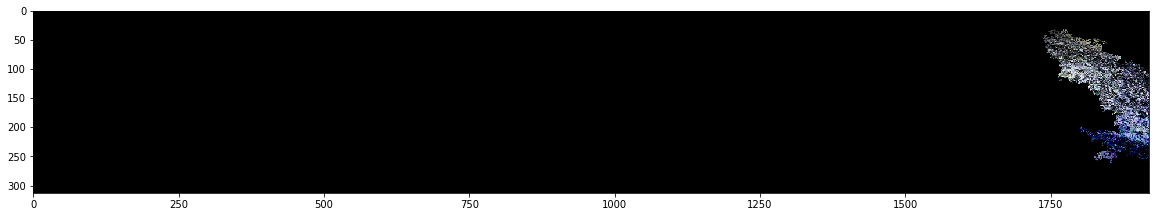

In [25]:
plt.figure(figsize=(20,25))
plt.imshow(mask)

What we want to do here is define the coordinates at we can crop the image for later classification. That can be done by going through the coordinates at which a specific segment is located and returning the min and max values respectively.

In [96]:
x_min = np.min(segment_locations[:, 0])
x_max = np.max(segment_locations[:, 0])
y_min = np.min(segment_locations[:, 1])
y_max = np.max(segment_locations[:, 1])

print(f" x_min = {x_min}\n x_max = {x_max}\n y_min = {y_min}\n y_max = {y_max}")

 x_min = 143
 x_max = 299
 y_min = 665
 y_max = 890


Crop the image using numpy

In [97]:
cropped_mask = mask[x_min:x_max, y_min:y_max, :]
cropped_mask.shape

(156, 225, 3)

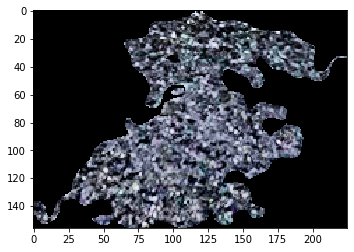

In [98]:
plt.imshow(cropped_mask)

## Save the segments as training data

Since we now have the raw data, we want to save it to some directory to then label it. 

In [27]:
IMAGE_PATH = "/home/daniel/Documents/data_science/data_cropped/gold/images"
TRAINING_DATA_PATH = "./training_data/raw"

In [28]:
def save_image(data_path, filename, image):
    if not os.path.exists(TRAINING_DATA_PATH):
        os.makedirs(TRAINING_DATA_PATH)
    
    p = os.path.join(TRAINING_DATA_PATH, filename)
    io.imsave(p, image)

Generate a random file name:

In [29]:
def random_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for x in range(size))

In [30]:
image_paths = glob.glob(IMAGE_PATH + "/*.jpg")

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#%%capture

for path in image_paths:

    img = io.imread(path)
    img = image_preprocessing(img)
    segs = slic(img, n_segments = N_SEGMENTS, sigma = 5)
    img_name = random_generator()
    
    print(path)
    
    for n_segment in range(N_SEGMENTS):
        
        # create a mask where only the segment is visible
        mask = np.zeros(img.shape[:2], dtype = "uint8")
        mask[segs == n_segment] = 255
        mask = cv2.bitwise_and(img, img, mask = mask)
        
        # crop out the segmented part
        segment_locations = np.argwhere(segs == n_segment)
        
        if len(segment_locations) > 0:
            x_min = np.min(segment_locations[:, 0])
            x_max = np.max(segment_locations[:, 0])
            y_min = np.min(segment_locations[:, 1])
            y_max = np.max(segment_locations[:, 1])

            cropped_mask = mask[x_min:x_max, y_min:y_max, :]
            plt.imshow(np.resize(cropped_mask, (200, 200)))
            save_image(path, img_name + "-" + str(n_segment) + ".jpg", cropped_mask )